In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='1'></a><br>
# Load and Check Data

In [3]:
NORMAL = "/content/drive/MyDrive/pneumonia dataset/NORMAL"
PNEUMONIA = "/content/drive/MyDrive/pneumonia dataset/PNEUMONIA"

In [4]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [5]:
img_data = []

for i in [NORMAL, PNEUMONIA]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

5856


In [6]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data)

In [7]:
data["labels"][0:1583] = 0 # NORMAL
data["labels"][1583:5856] = 1 # PNEUMONIA

<ipython-input-7-db89bdc32fba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:1583] = 0 # NORMAL
<ipython-input-7-db89bdc32fba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][1583:5856] = 1 # PNEUMONIA


In [8]:
data["labels"] = data["labels"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

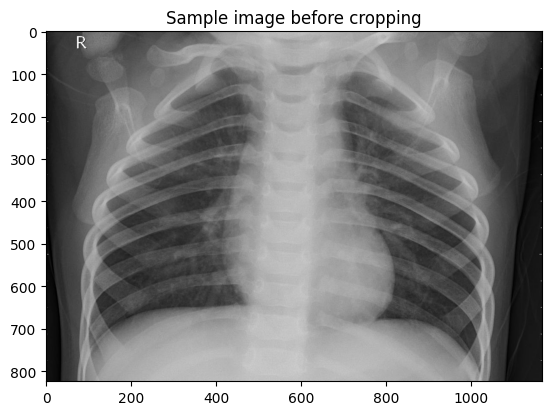

In [9]:
image = cv.imread(data["img_data"][433])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [10]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)

<a id='3'></a><br>
# Feature Extraction with MobileNet

In [11]:
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50,MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [12]:
input_shape = (224, 224, 3)
inputs = Input(input_shape)

mob = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

17225924/17225924 [==============================] - 0s 0us/step


In [13]:
model = GlobalAveragePooling2D()(mob)
model = Model(inputs, model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 3228864 (12.32 MB)
Trainable params: 3206976 (12.23 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [15]:
features_list = []
for i in range(len(img_list)):

    image = img_list[i].reshape(-1, 224, 224, 3)
    features = model.predict(image).reshape(1024,)

    features_list.append(features)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step


In [17]:
features_df = pd.DataFrame(features_list)

In [18]:
features_df["labels"] = data["labels"]

In [19]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [20]:
x

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.728316,0.013993,0.000000,0.118568,0.000000,0.000000,0.000000,0.565640,0.001279,0.039739,...,0.284427,0.070003,0.000000,0.060026,0.046412,0.629569,2.461580,0.541818,0.000000,0.032133
1,0.350734,0.000000,0.000000,0.001295,0.000000,0.000000,0.000000,0.315788,0.000000,0.000000,...,0.653926,0.224488,0.000000,0.000000,0.000000,0.031942,2.739916,0.637392,0.000000,0.075594
2,1.036081,0.008517,0.000000,0.031114,0.000000,0.000000,0.142304,0.485482,0.011416,0.353415,...,0.220041,0.226626,0.000000,0.443864,0.121598,1.364940,1.627711,0.803560,0.248594,0.209468
3,0.840485,0.000000,0.000000,0.025006,0.000000,0.000000,0.000000,0.130722,0.000000,0.145280,...,0.725479,0.427165,0.000000,0.140796,0.027235,0.163350,1.929132,1.065255,0.000746,0.479312
4,0.549096,0.017917,0.519579,0.022991,0.335048,0.000000,0.028636,0.694373,0.006564,0.749134,...,1.836103,0.514065,0.007210,0.345714,0.000000,0.623895,1.808641,1.285044,0.234554,0.303801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,0.719244,0.099257,0.682326,0.389775,1.060236,0.039895,0.048645,0.802935,0.000000,1.220815,...,2.661455,1.058996,0.073511,0.597687,0.035146,0.153546,2.084452,1.928819,0.318675,1.740997
5852,0.547607,0.133738,0.884943,0.030687,0.188708,0.000000,0.031622,0.219476,0.000000,0.406956,...,2.003151,0.485872,0.057567,0.674254,0.090079,0.089590,2.373462,1.179825,0.000000,0.373868
5853,0.085584,0.000000,0.000000,0.029998,0.000000,0.014868,0.026675,0.004563,0.000000,0.000000,...,1.021941,0.670306,0.000000,0.000000,0.664598,0.354822,3.126692,1.375212,0.000000,0.016295
5854,0.663736,0.041351,0.280924,0.516293,0.702143,0.045713,0.048973,1.024691,0.000000,1.379098,...,0.618421,1.079424,0.000000,0.868510,0.032947,0.358759,2.649491,0.647071,0.013430,0.857470


In [21]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [22]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 1024


<a id='4'></a><br>
# Data Scaling

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [24]:
x_ = pd.DataFrame(x_)

<a id='9'></a><br>
# Train Test Split

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [26]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [27]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.9189419795221843 with K = 7


In [28]:
knn = KNeighborsClassifier(n_neighbors= 7)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.5f' % (knn_score_))

Accuracy : 0.91894


In [29]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))


              precision    recall  f1-score   support

           0       0.86      0.87      0.86       341
           1       0.94      0.94      0.94       831

    accuracy                           0.92      1172
   macro avg       0.90      0.90      0.90      1172
weighted avg       0.92      0.92      0.92      1172



In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.91894 Precision: 0.94444  Recall: 0.94103 Error Rate: 0.08106 F1 Score: 0.94274 AUC Score: 0.90307


Confusion matrix, without normalization
[[295  46]
 [ 49 782]]


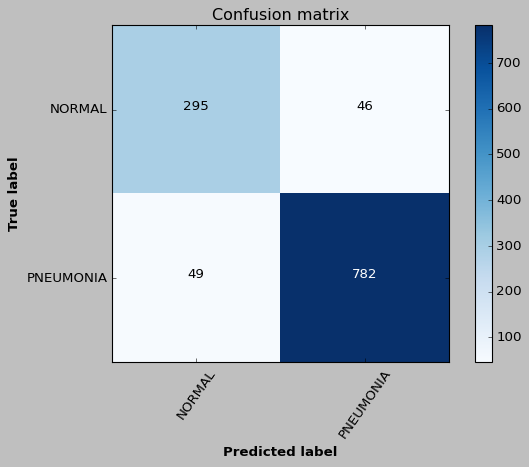

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test, predicted)


cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')
plt.savefig('CM1',dpi=400)

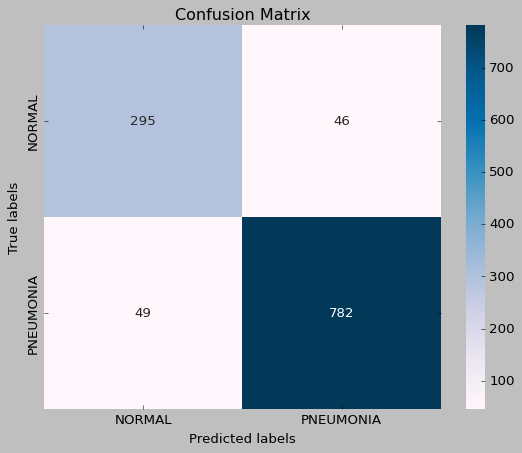

In [32]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap1',dpi=400)
plt.show()

<ipython-input-33-c6c642de1969>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


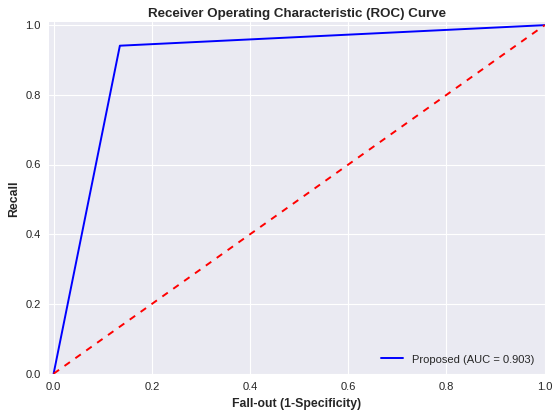

In [33]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve1',dpi=400)
plt.show()

In [34]:
classes = ['NORMAL', 'PNEUMONIA']
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

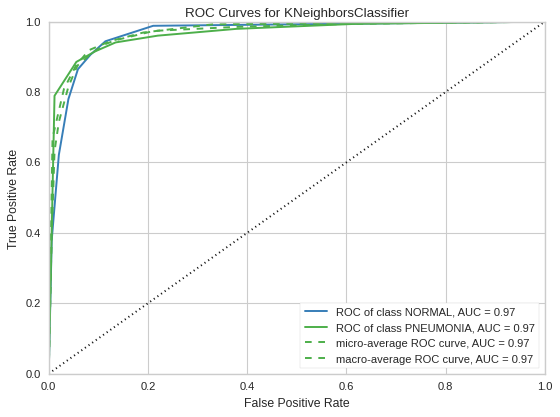

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [35]:
classes = ['NORMAL', 'PNEUMONIA']
visualizer = ROCAUC(knn, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
plt.savefig('ROC curve1',dpi=400)
visualizer.show()

<a id='12'></a><br>
## SVM

In [36]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [37]:
print(SVM_grid.best_params_)

print(SVM_grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)


In [38]:
svm_clf = svm.SVC(C=100, gamma=0.0001, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.5f' % (svm_score_))

Accuracy : 0.94283


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.94283 Precision: 0.95476  Recall: 0.96510 Error Rate: 0.05717 F1 Score: 0.95990 AUC Score: 0.92683


Confusion matrix, without normalization
[[303  38]
 [ 29 802]]


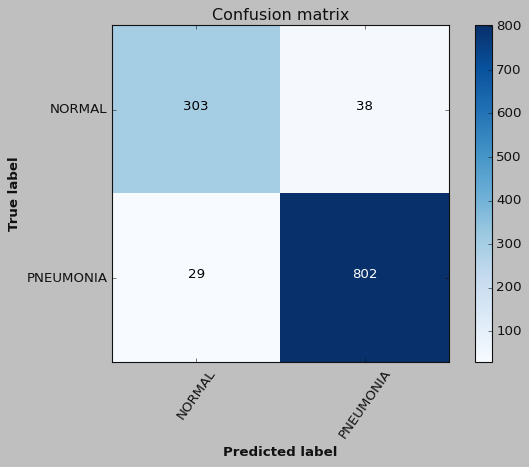

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test, predicted)


cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')
plt.savefig('CM22',dpi=400)

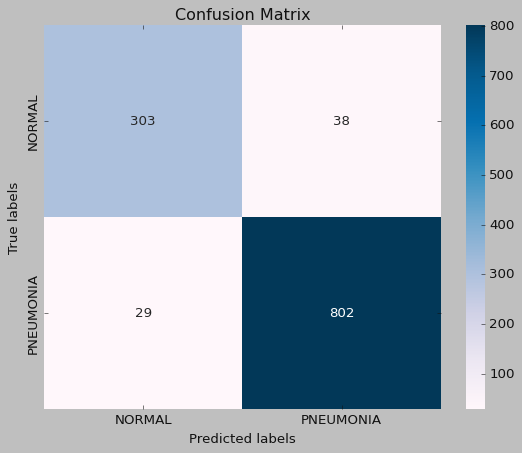

In [41]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap22',dpi=400)
plt.show()

<ipython-input-42-a2ce98955347>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


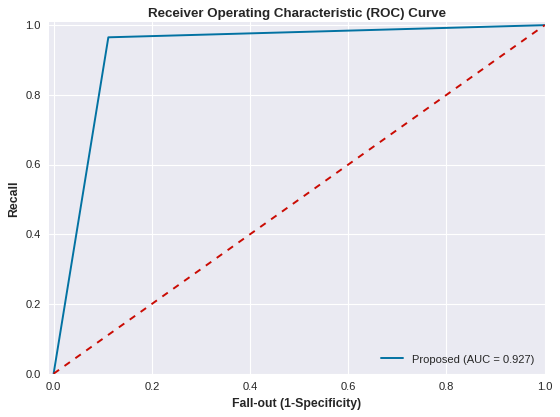

In [42]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve22',dpi=400)
plt.show()

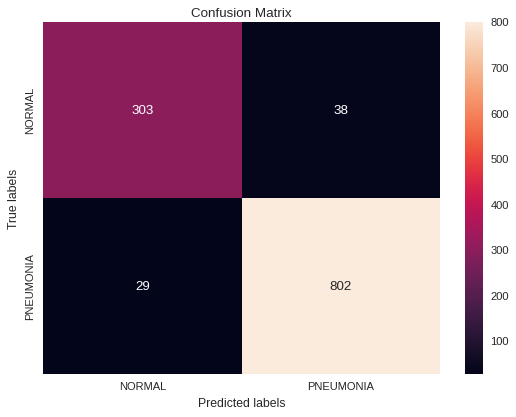

In [43]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap23',dpi=400)
plt.show()

<a id='13'></a><br>
## Random Forest

In [44]:
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [45]:
print(RF_grid.best_params_)

{'max_depth': 8, 'n_estimators': 500}


In [46]:
r_forest = RandomForestClassifier(500,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.5f' % (rf_score_))

Accuracy : 0.89846


In [47]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       341
           1       0.91      0.95      0.93       831

    accuracy                           0.90      1172
   macro avg       0.89      0.86      0.87      1172
weighted avg       0.90      0.90      0.90      1172



In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.89846 Precision: 0.90826  Recall: 0.95307 Error Rate: 0.10154 F1 Score: 0.93012 AUC Score: 0.85923


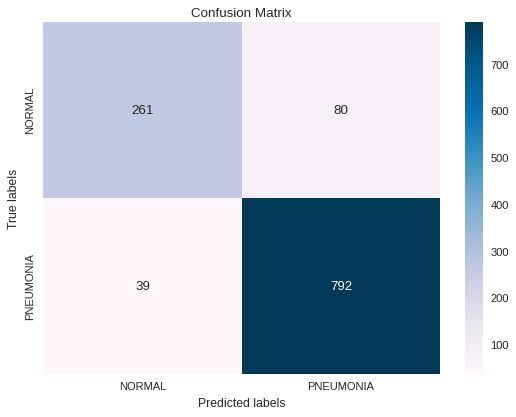

In [49]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap4',dpi=400)
plt.show()

<ipython-input-50-35c6ec2c20cc>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


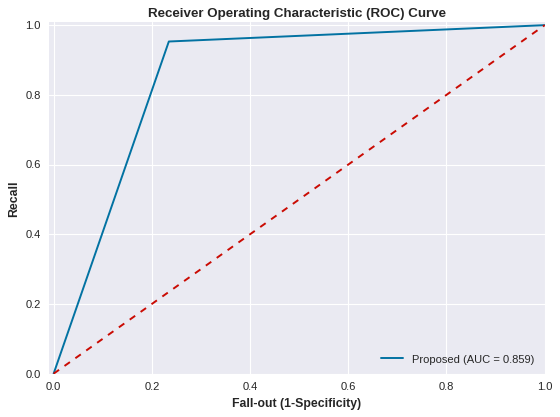

In [50]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve4',dpi=400)
plt.show()

<a id='14'></a><br>
## Naive Bayes

In [51]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)
nb_score_ = np.mean(score)

print('Accuracy : %.5f' % (nb_score_))

Accuracy : 0.86007


In [52]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.71      0.88      0.79       341
           1       0.95      0.85      0.90       831

    accuracy                           0.86      1172
   macro avg       0.83      0.87      0.84      1172
weighted avg       0.88      0.86      0.86      1172



In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.86007 Precision: 0.94526  Recall: 0.85199 Error Rate: 0.13993 F1 Score: 0.89620 AUC Score: 0.86588


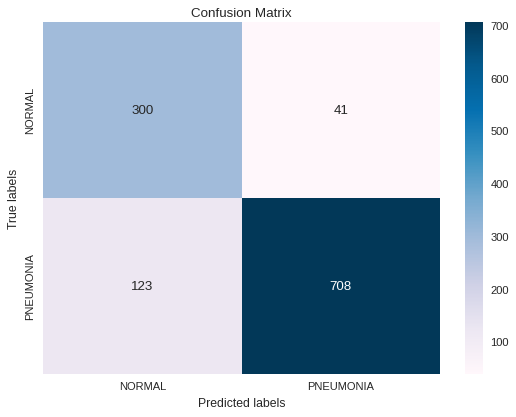

In [54]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap5',dpi=400)
plt.show()

<ipython-input-55-abdb76e5e069>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


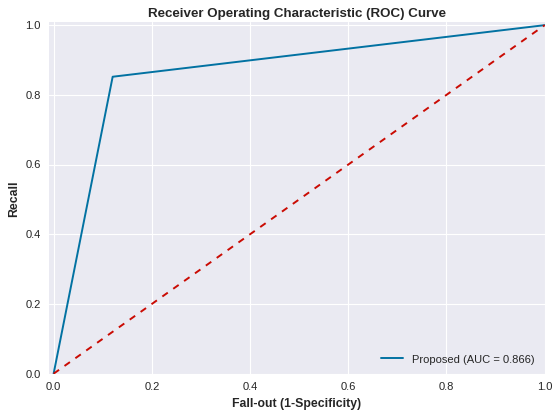

In [55]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve5',dpi=400)
plt.show()

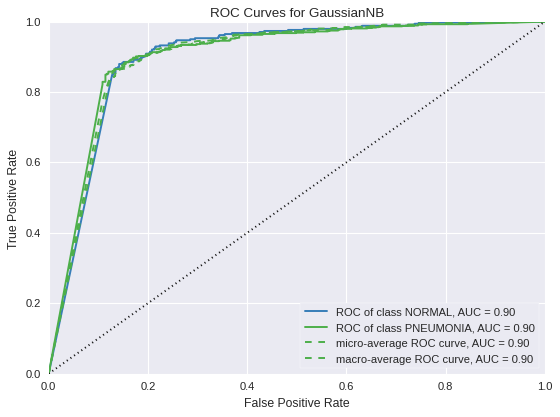

<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [56]:
classes = ['NORMAL', 'PNEUMONIA']
visualizer = ROCAUC(nb_model, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
plt.savefig('ROC curve5',dpi=400)
visualizer.show()